pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.


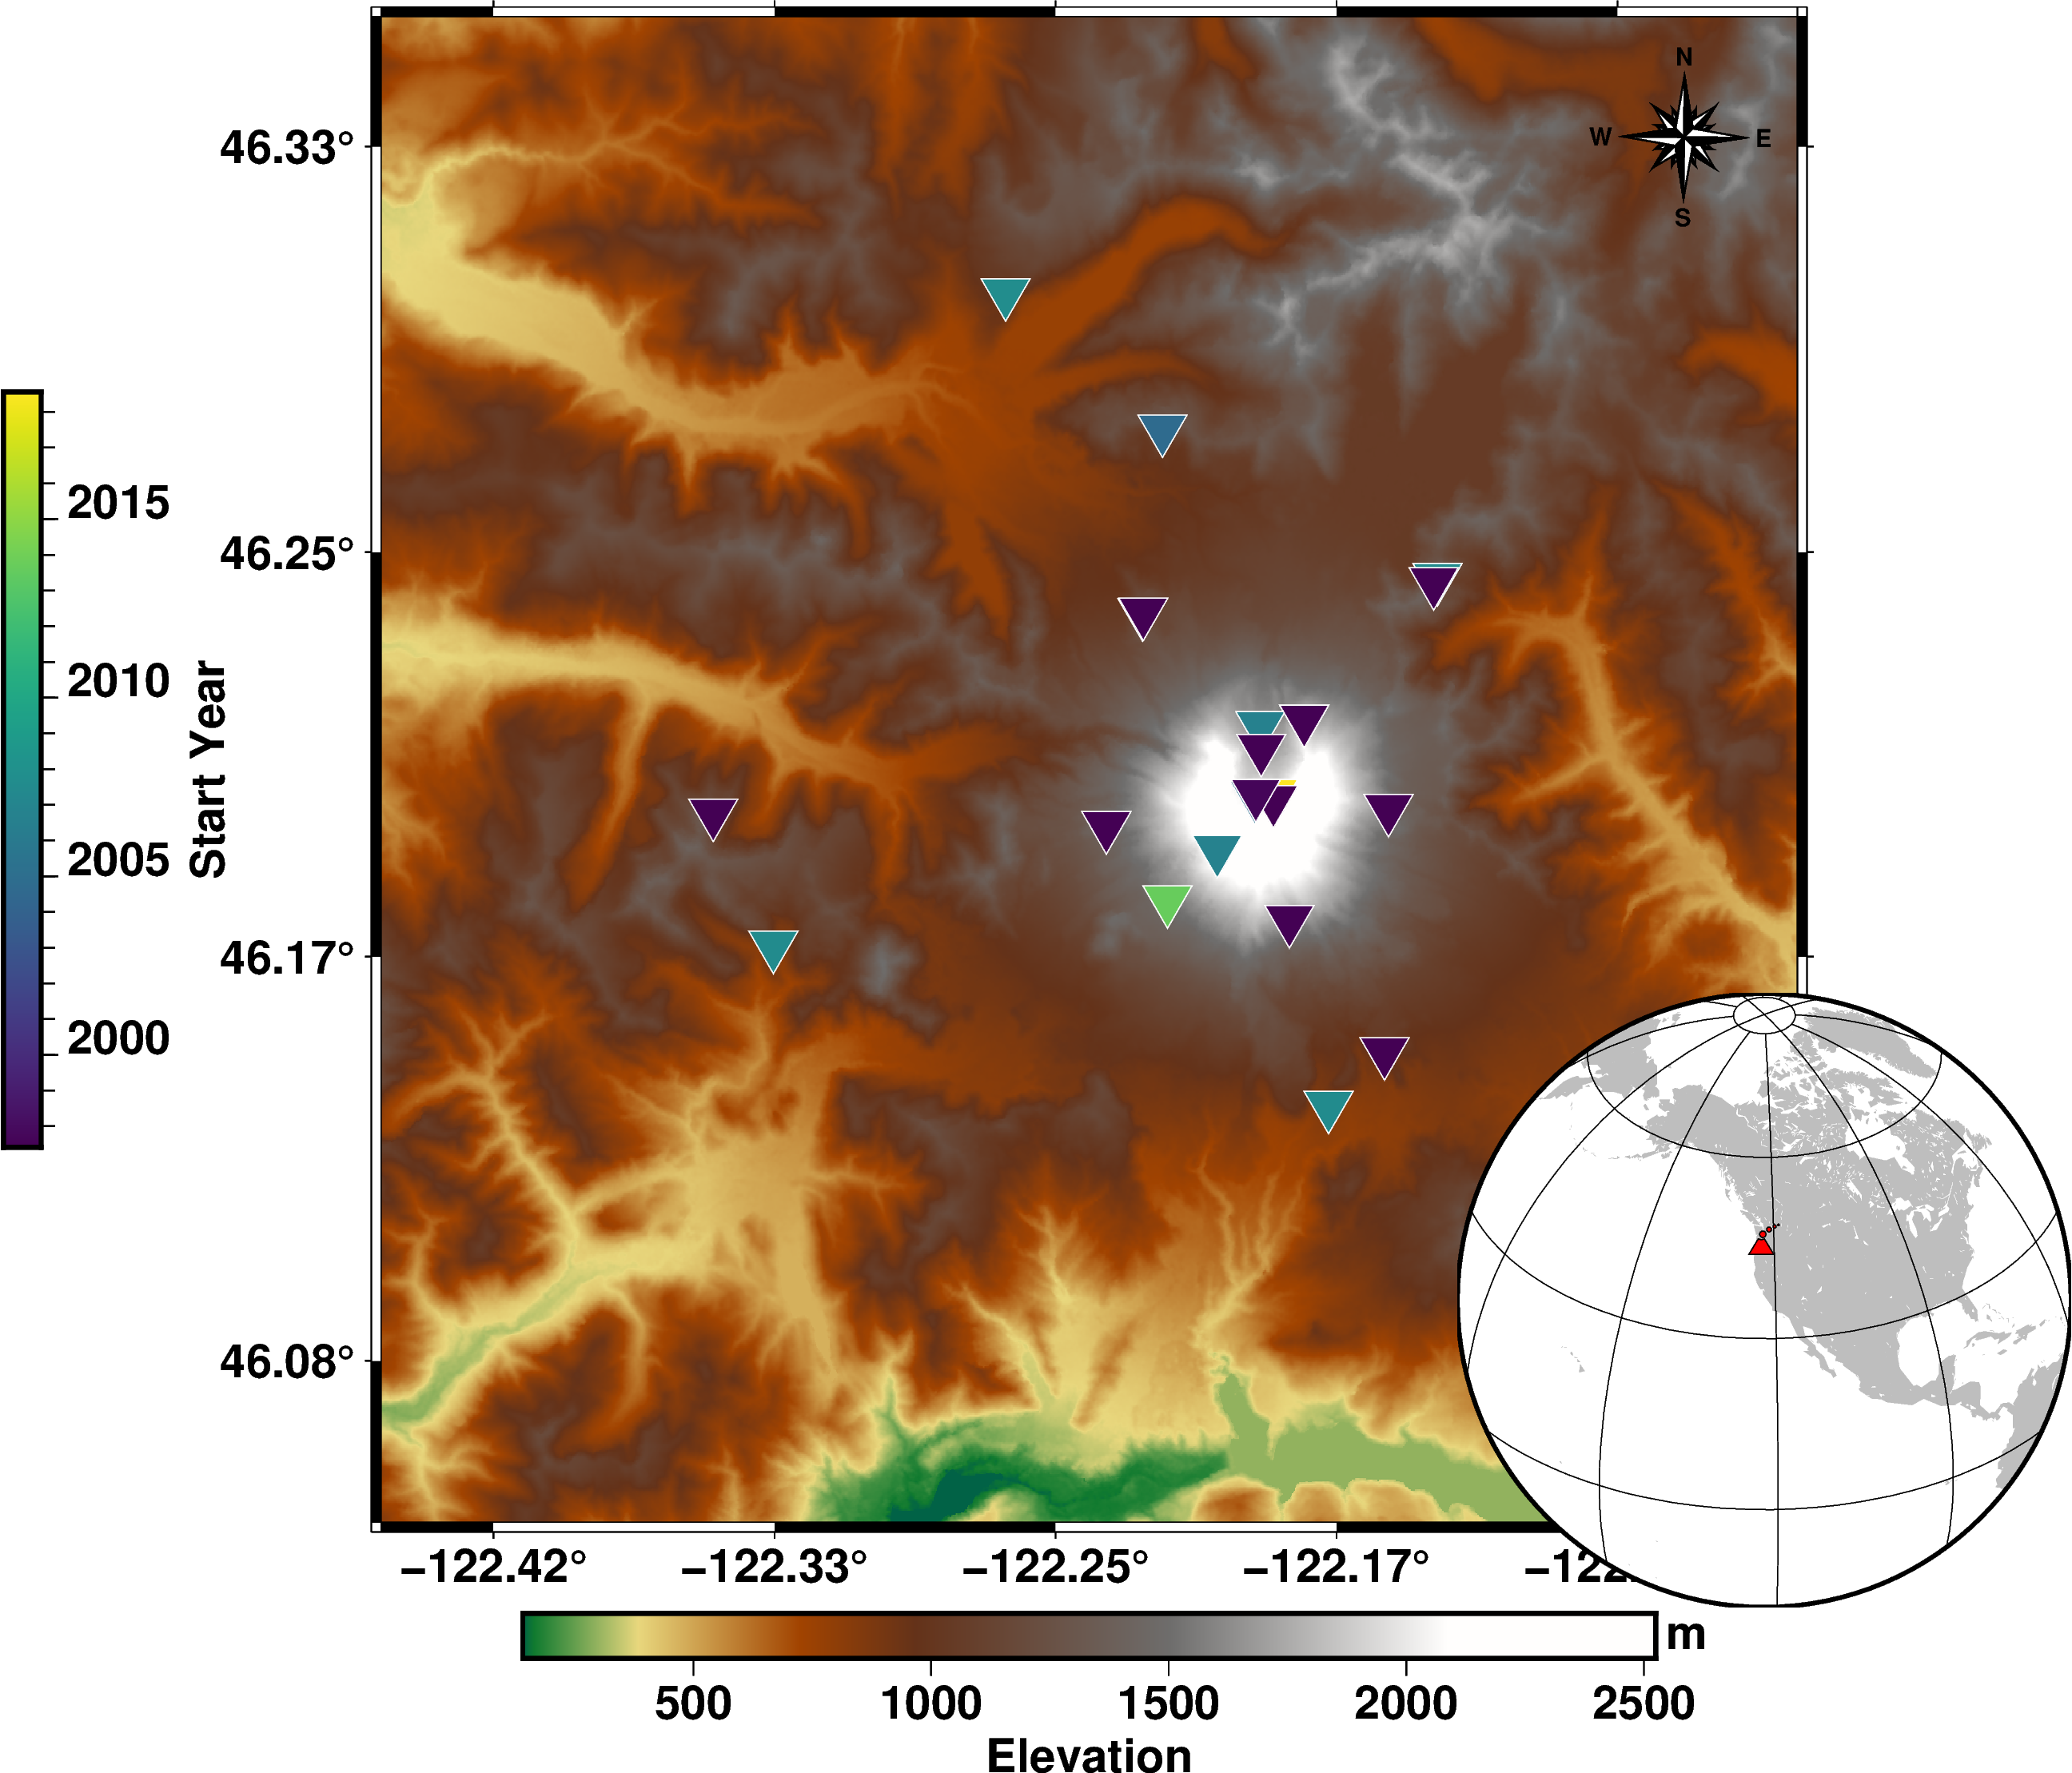

In [2]:
import numpy as np
import pygmt
import pandas as pd

import datetime

stats = pd.read_csv('stat_locs.txt', sep='|', header=0)
stats['StartTime'] = pd.to_datetime(stats['StartTime'])
# replace starttime by June 1, 1997 if it is before that
stats.loc[stats.StartTime < datetime.datetime(1997, 6, 1), 'StartTime'] = datetime.datetime(1997, 6, 1)
# 2 is lat 3 is lon
region = [
    stats.Longitude.min() - .5,
    stats.Longitude.max() + .5,
    stats.Latitude.min() - .5,
    stats.Latitude.max() + .5,
]
region = [
    -122.45,
    -122.03,
    46.05,
    46.36,
]

helen = (46.191, -122.196)


pygmt.config(FONT='14p,Helvetica-Bold', FORMAT_GEO_MAP="ddd.xx")

fig = pygmt.Figure()
# relief
grid = pygmt.datasets.load_earth_relief(resolution='01s', region=region)
fig.grdimage(grid=grid, projection="M15c", cmap="geo")
# make coordinates in decimal degrees
fig.basemap(
    region=region, projection="M15c", frame=["a"], rose="n0.92/0.92+w1.3c+f3+l")


fig.colorbar(frame=["a500", "x+lElevation", "y+lm"])
pygmt.makecpt(
    cmap="viridis", series=[min(stats.StartTime), max(stats.StartTime)])
fig.plot(
    x=stats.Longitude, y=stats.Latitude, style="i0.6c", cmap=True,
    color=stats.StartTime, pen="white", label=f'{stats.Network[0]}.{stats.Station[0]}')
# plot vertical ground motion as squares

# put the colorbar for the vertical offset
# left of the plot, centered, and vertical
# put colorbar further left
# put the label closer to the colorbar
fig.colorbar(
    frame="x+lStart Year", #position="JML+o-1.5c/0c+w3c/0.3c+h")
    position="jml+o-4c/0c+w8c/0.4c")#position="JML+o3c/0c+w9c")
# fig.plot(
#     x=helen[1], y=helen[0], style="kvolcano/1c", color="red", pen="white",
#     label='Volcanoes')


lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
    fig.coast(
        projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
        land="gray", water='white')
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.33c", color="red",
        pen="black", projection=f"G{lonmid}/{latmid}/60/6.5c")

fig.savefig('../paper/figures/station_map.png', dpi=300, transparent=True)
# fig.savefig('station_map.pdf' transparent=True)

fig.show()
